In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from monte_carlo import monte_carlo, monte_carlo_numpy
from bs import BlackScholes

# Пример вычисления цен


In [ ]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
alpha = 0.8
N = 5_000_000

price_call, _ = monte_carlo(S0, K, T, r, sigma, alpha, N, call=True)
price_put, _ = monte_carlo(S0, K, T, r, sigma, alpha, N, call=False)
print(f'(CALL) Monte-Carlo method (alpha = {alpha}) price = {price_call:.4f}')
print(f'(PUT) Monte-Carlo method (alpha = {alpha}) price = {price_put:.4f}\n')

alpha_classic = 1.0
price_classic_call, _ = monte_carlo(
    S0, K, T, r, sigma, alpha_classic, N, call=True)
price_classic_put, _ = monte_carlo(
    S0, K, T, r, sigma, alpha_classic, N, call=False)
print(
    f'(CALL) Monte-Carlo method (alpha = {alpha_classic}) price = {price_classic_call:.4f}')
print(
    f'(PUT) Monte-Carlo method (alpha = {alpha_classic}) price = {price_classic_put:.4f}\n')

model = BlackScholes(sigma, r)
print(
    f'(CALL) Analytic solution (alpha = 1.0) price = {model.call_price(S0, T, K):.4f}')
print(
    f'(PUT) Analytic solution (alpha = 1.0) price = {model.put_price(S0, T, K):.4f}\n')

(CALL) Monte-Carlo method (alpha = 0.8) price = 10.6088
(PUT) Monte-Carlo method (alpha = 0.8) price = 5.4037

(CALL) Monte-Carlo method (alpha = 1.0) price = 10.4525
(PUT) Monte-Carlo method (alpha = 1.0) price = 5.5697

(CALL) Analytic solution (alpha = 1.0) price = 10.4506
(PUT) Analytic solution (alpha = 1.0) price = 5.5735



# График зависимости цены от числа симуляций


In [8]:
n_list = [i * 20_000 for i in range(1, 800)]
prices = []

S0 = 100
K = 110
T = 1.0
r = 0.05
sigma = 0.2
alpha = 0.8

for N in n_list:
    price, _ = monte_carlo(S0, K, T, r, sigma, alpha, size=N, call=True)
    prices.append(price)

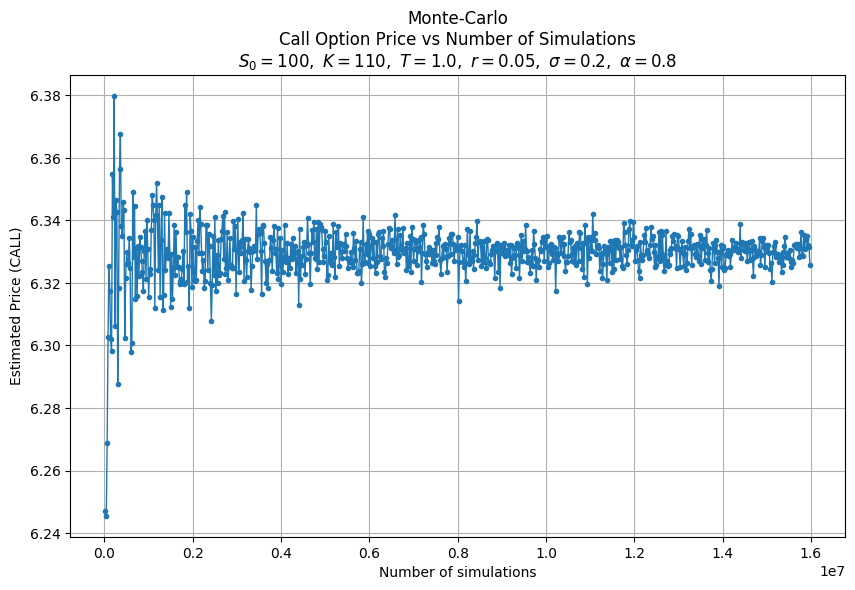

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(n_list, prices, marker='o', markersize=3, linewidth=1)
plt.title(
    f'Monte-Carlo\nCall Option Price vs Number of Simulations\n'
    f'$S_0={S0},\\ K={K},\\ T={T},\\ r={r},\\ \\sigma={sigma},\\ \\alpha={alpha}$'
)
plt.xlabel('Number of simulations')
plt.ylabel('Estimated Price (CALL)')
plt.grid(True)
plt.show()

# Сравнение скоростей работы двух реализаций

Реализации:

1. Numpy (название функции monte_carlo_numpy)
2. Numpy + numba (название функции monte_carlo)


In [12]:
S0, K, T, r, sigma, alpha = 100.0, 110.0, 1.0, 0.05, 0.2, 0.8
N = 1_000_000
repeats = 100

monte_carlo(S0, K, T, r, sigma, alpha, 10_000, True)

times_numpy = []
times_numba = []

for _ in range(repeats):
    start = time.perf_counter()
    monte_carlo_numpy(S0, K, T, r, sigma, alpha, N, True)
    times_numpy.append(time.perf_counter() - start)

    start = time.perf_counter()
    monte_carlo(S0, K, T, r, sigma, alpha, N, True)
    times_numba.append(time.perf_counter() - start)

avg_numpy = sum(times_numpy) / repeats
avg_numba = sum(times_numba) / repeats
speedup = avg_numpy / avg_numba

df = pd.DataFrame({
    "function": ["numpy", "numpy + numba"],
    "avg Time (s)": [avg_numpy, avg_numba],
    "speedup": [1.0, speedup]
})

print(df.to_string(index=False))

     function  avg Time (s)  speedup
        numpy      0.101595 1.000000
numpy + numba      0.028555 3.557834


Получили ускорение работы в 3.5 раза. Теперь стоит проверить не сломались ли вычисления, с numba иногда такое бывает...


In [4]:
monte_carlo(100.0, 100.0, 1.0, 0.05, 0.2, 0.8, 10_000, True)

ranges = {
    'S0':    (90.0, 110.0),
    'K':     (90.0, 110.0),
    'T':     (0.1,   1.0),
    'r':     (0.03,  0.08),
    'sigma': (0.15,  0.25),
    'alpha': (0.1,   1.0),
}

M = 500
N = 1_000_000

rng = np.random.default_rng()

S0_val = rng.uniform(*ranges['S0'], size=M)
K_val = rng.uniform(*ranges['K'], size=M)
T_val = rng.uniform(*ranges['T'], size=M)
r_val = rng.uniform(*ranges['r'], size=M)
sigma_val = rng.uniform(*ranges['sigma'], size=M)
alpha_val = rng.uniform(*ranges['alpha'], size=M)

call_flags = rng.choice([True, False], size=M)

means_np = np.empty(M)
means_nb = np.empty(M)

for i in range(M):
    S0 = S0_val[i]
    K = K_val[i]
    T = T_val[i]
    r = r_val[i]
    sigma = sigma_val[i]
    alpha = alpha_val[i]
    call = call_flags[i]

    mean_np, _ = monte_carlo_numpy(S0, K, T, r, sigma, alpha, N, call)
    mean_nb, _ = monte_carlo(S0, K, T, r, sigma, alpha, N, call)

    means_np[i] = mean_np
    means_nb[i] = mean_nb

diff = means_nb - means_np
MAE = np.mean(np.abs(diff))
MAPE = np.mean(np.abs(diff / means_np)) * 100

print(f"MAE  = {MAE:.4f}")
print(f"MAPE = {MAPE:.2f}%")

MAE  = 0.0115
MAPE = 0.20%


### Результаты сравнения:

1. MAE = 0.0115
2. MAPE = 0.20%

Ошибка в пределах дисперсии, что видно из графика выше (График зависимости цены от числа симуляций)


# Таблица для цен опционов


In [ ]:
def generate_report_table():
    S0 = 100
    K = 110
    T = 1.0
    r = 0.05
    sigma = 0.2
    N = 5_000_000

    alphas_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    results_data = []

    for alpha in alphas_to_test:
        price_call, stderr_call = monte_carlo(
            S0, K, T, r, sigma, alpha, N, call=True)
        results_data.append({
            'method': 'Monte-Carlo',
            'alpha': alpha,
            'type': 'call',
            'price': f'{price_call:.4f}',
            'std error': f'{stderr_call:.4f}',
        })

        price_put, stderr_put = monte_carlo(
            S0, K, T, r, sigma, alpha, N, call=False)
        results_data.append({
            'method': 'Monte-Carlo',
            'alpha': alpha,
            'type': 'put',
            'price': f'{price_put:.4f}',
            'std error': f'{stderr_put:.4f}',
        })

    bs_model = BlackScholes(sigma=sigma, r=r)
    analytical_call = bs_model.call_price(S0, T, K)
    analytical_put = bs_model.put_price(S0, T, K)

    results_data.append({
        'method': 'Analytical B-S',
        'type': 'call',
        'price': f'{analytical_call:.4f}'
    })
    results_data.append({
        'method': 'Analytical B-S',
        'type': 'put',
        'price': f'{analytical_put:.4f}'
    })

    df = pd.DataFrame(results_data)
    df = df[['method', 'alpha', 'type', 'price', 'std error']]

    print('description')
    print(f'params: S0={S0}, K={K}, T={T}, r={r}, sigma={sigma}')
    print(f'number of simulations for Monte-Carlo method: {N}\n')
    print(df.to_string(index=False))

In [25]:
generate_report_table()

description
params: S0=100, K=110, T=1.0, r=0.05, sigma=0.2
number of simulations for Monte-Carlo method: 5000000

        method  alpha type   price std error
   Monte-Carlo    0.1 call  5.8774    0.0067
   Monte-Carlo    0.1  put 10.3722    0.0049
   Monte-Carlo    0.2 call  6.0943    0.0068
   Monte-Carlo    0.2  put 10.4089    0.0050
   Monte-Carlo    0.3 call  6.2720    0.0068
   Monte-Carlo    0.3  put 10.4301    0.0051
   Monte-Carlo    0.4 call  6.3839    0.0067
   Monte-Carlo    0.4  put 10.4552    0.0051
   Monte-Carlo    0.5 call  6.4431    0.0066
   Monte-Carlo    0.5  put 10.4963    0.0052
   Monte-Carlo    0.6 call  6.4550    0.0064
   Monte-Carlo    0.6  put 10.5453    0.0052
   Monte-Carlo    0.7 call  6.4102    0.0062
   Monte-Carlo    0.7  put 10.5721    0.0053
   Monte-Carlo    0.8 call  6.3253    0.0059
   Monte-Carlo    0.8  put 10.6170    0.0053
   Monte-Carlo    0.9 call  6.2100    0.0056
   Monte-Carlo    0.9  put 10.6409    0.0053
   Monte-Carlo    1.0 call  6.